In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models, layers

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
pip install kaggle


In [ ]:
mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d dev523/leaf-disease-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/dev523/leaf-disease-detection-dataset
License(s): CC0-1.0
leaf-disease-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip leaf-disease-detection-dataset.zip

Archive:  leaf-disease-detection-dataset.zip
replace dataset/test/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_270deg.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

IMAGE_SIZE = 128
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 10

In [ ]:
tf.keras.backend.clear_session()
import gc
gc.collect()

0

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "dataset/train",
  shuffle=True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE
)


Found 70295 files belonging to 38 classes.


In [ ]:
class_names= dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

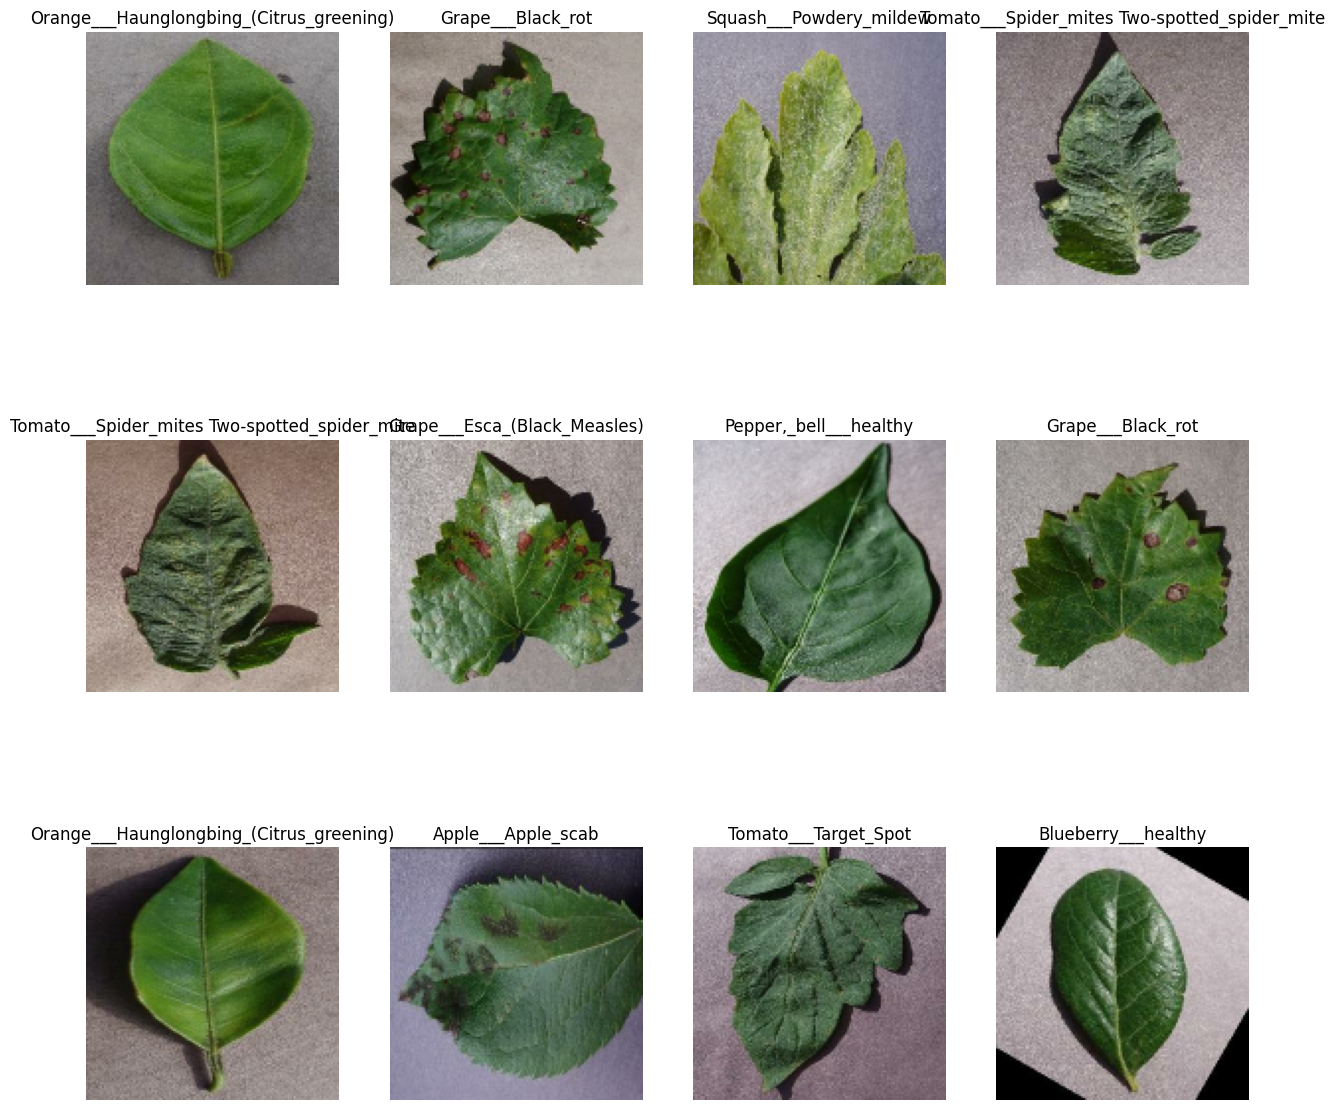

In [ ]:
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=300):
    assert (train_split  + val_split) == 1
    ds_size = tf.data.experimental.cardinality(ds).numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)


    return train_ds, val_ds

# Partition the dataset
train_ds, val_ds = get_dataset_partitions_tf(dataset)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names



Found 17572 files belonging to 38 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
# train_ds = train_ds.map(
    # lambda x, y: (data_augmentation(x, training=True), y)
# ).cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE ,CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 128, 128, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (16, 127, 127, 32)        416       
                                                                 
 max_pooling2d_6 (MaxPoolin  (16, 63, 63, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (16, 62, 62, 64)          8256      
                                                                 
 max_pooling2d_7 (MaxPoolin  (16, 31, 31, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (16, 30, 30, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the model
data_hist = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/10
3954/3954 [==============================] - 124s 27ms/step - loss: 1.9210 - accuracy: 0.4358 - val_loss: 0.9480 - val_accuracy: 0.7031
Epoch 2/10
3954/3954 [==============================] - 98s 24ms/step - loss: 0.7363 - accuracy: 0.7644 - val_loss: 0.5282 - val_accuracy: 0.8224
Epoch 3/10
3954/3954 [==============================] - 100s 24ms/step - loss: 0.4884 - accuracy: 0.8398 - val_loss: 0.4132 - val_accuracy: 0.8639
Epoch 4/10
3954/3954 [==============================] - 97s 24ms/step - loss: 0.3896 - accuracy: 0.8702 - val_loss: 0.3771 - val_accuracy: 0.8757
Epoch 5/10
3954/3954 [==============================] - 98s 24ms/step - loss: 0.3147 - accuracy: 0.8950 - val_loss: 0.2482 - val_accuracy: 0.9150
Epoch 6/10
3954/3954 [==============================] - 103s 25ms/step - loss: 0.2752 - accuracy: 0.9077 - val_loss: 0.2228 - val_accuracy: 0.9284
Epoch 7/10
3954/3954 [==============================] - 96s 24ms/step - loss: 0.2417 - accuracy: 0.9192 - val_loss: 0.213

In [ ]:
scores = model.evaluate(test_ds)

1099/1099 [==============================] - 17s 15ms/step - loss: 0.2109 - accuracy: 0.9311


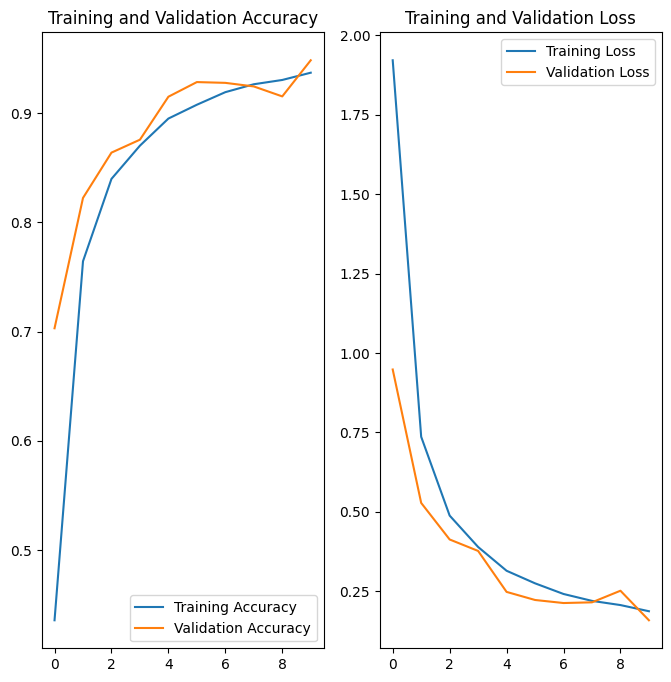

In [ ]:
acc = data_hist.history['accuracy']
val_acc = data_hist.history['val_accuracy']

loss = data_hist.history['loss']
val_loss = data_hist.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 24ms/step


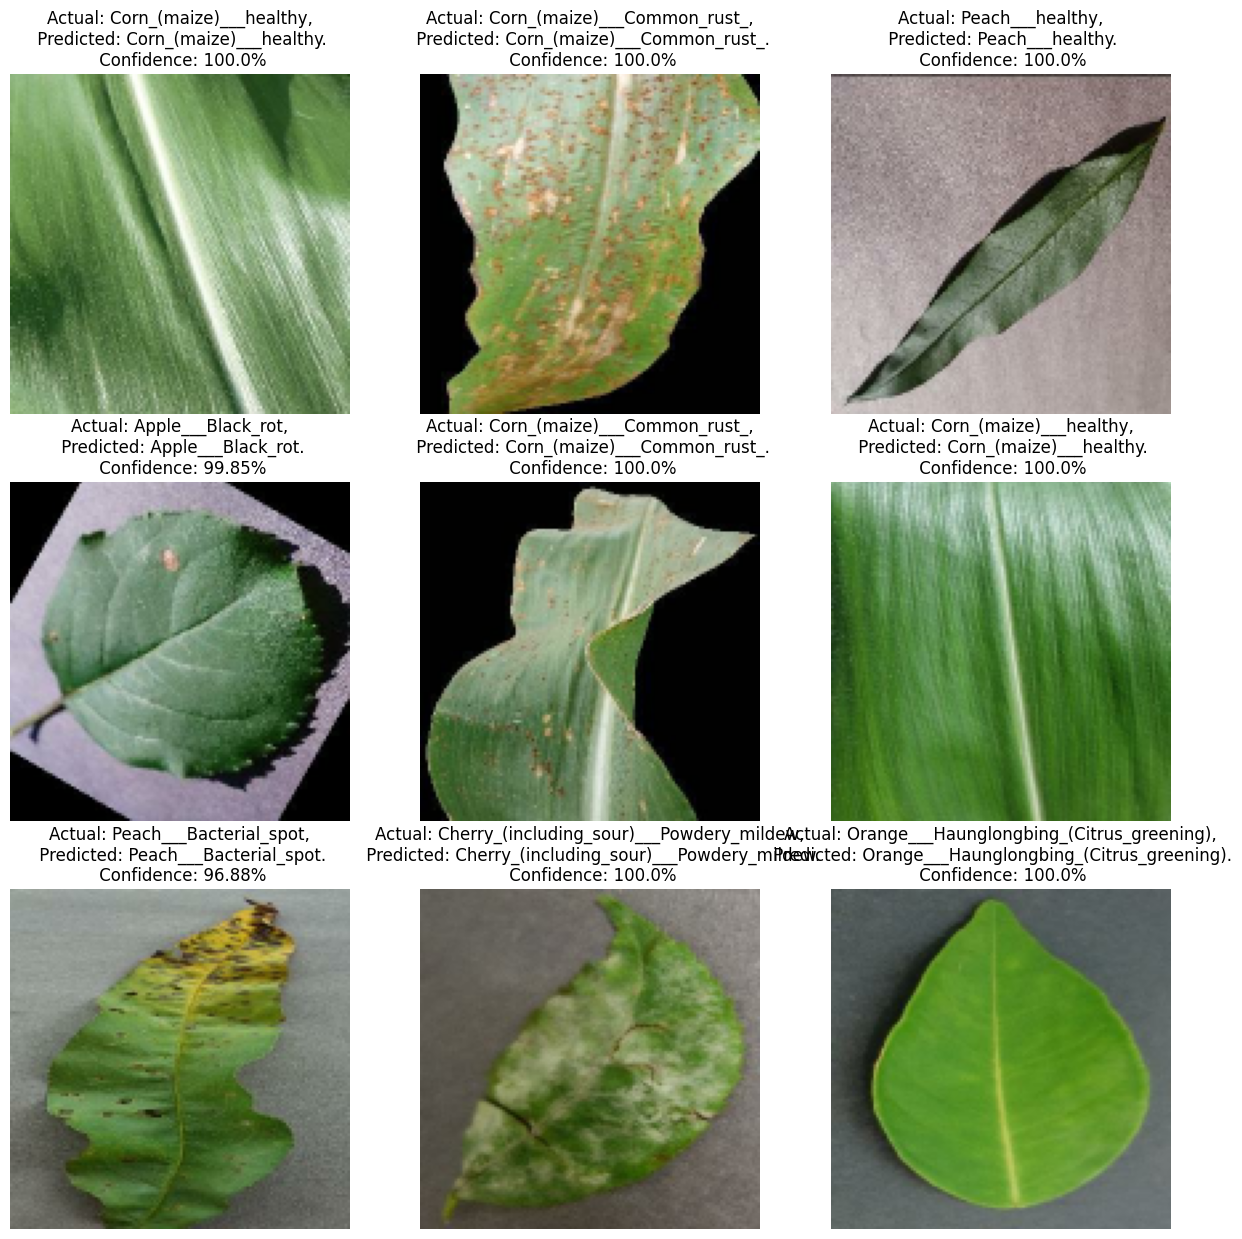

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")